# Deep Learning Approach for Human Identification using Inertial Signals

## Importing Dependencies

In [22]:
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM, ConvLSTM2D
from keras.layers import Permute, Reshape
from keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics

In [23]:
import os
os.getcwd()
os.chdir(r"C:\Users\Vishal Sahni\Desktop\Docu3c_Internship\Gait_Analysis\UCI HAR Dataset")

In [24]:
os.getcwd()

'C:\\Users\\Vishal Sahni\\Desktop\\Docu3c_Internship\\Gait_Analysis\\UCI HAR Dataset'

## Functions to load Inertial Signals

In [25]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [26]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [27]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    print('File Path : ',filepath)
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/subject_'+group+'.txt')
    return X, y

In [28]:
# load Features and Labels
X, Y = load_dataset_group('train', 'C:/Users/Vishal Sahni/Desktop/Docu3c_Internship/Gait_Analysis/UCI HAR Dataset/')

# zero-offset class values
Y = Y - 1

# one hot encode y
Y = to_categorical(Y)

print('X.shape : ', X.shape)
print('Y.shape : ', Y.shape)

File Path :  C:/Users/Vishal Sahni/Desktop/Docu3c_Internship/Gait_Analysis/UCI HAR Dataset/train/Inertial Signals/
X.shape :  (7352, 128, 9)
Y.shape :  (7352, 30)


## Reshaping and Spliting the data 

In [29]:
from sklearn.model_selection import train_test_split

# Reshape the input data to (samples, features)
X = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Reshape the input data back to its original shape
X_train = X_train.reshape(X_train.shape[0], 128, 9)
X_test = X_test.reshape(X_test.shape[0], 128, 9)


print('X_train.shape : ', X_train.shape)
print('Y_train.shape : ', Y_train.shape)
print('X_test.shape : ', X_test.shape)
print('Y_test.shape : ', Y_test.shape)

X_train.shape :  (5146, 128, 9)
Y_train.shape :  (5146, 30)
X_test.shape :  (2206, 128, 9)
Y_test.shape :  (2206, 30)


In [30]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_train.shape[1]

# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32

X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))

X_train.shape :  (5146, 4, 1, 32, 9)
X_test.shape :  (2206, 4, 1, 32, 9)


## Implementing and Training the RNN model

In [31]:
verbose = 1
epochs = 30
batch_size = 20

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
hist = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test), batch_size=batch_size, verbose=verbose)

# evaluate model
(loss, accuracy) = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=verbose)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

Epoch 1/30
258/258 [==============================] - 8s 25ms/step - loss: 2.7319 - accuracy: 0.1627 - val_loss: 2.2903 - val_accuracy: 0.2570
Epoch 2/30
258/258 [==============================] - 6s 24ms/step - loss: 2.0010 - accuracy: 0.3515 - val_loss: 1.8007 - val_accuracy: 0.4356
Epoch 3/30
258/258 [==============================] - 6s 25ms/step - loss: 1.5699 - accuracy: 0.4825 - val_loss: 1.4823 - val_accuracy: 0.5136
Epoch 4/30
258/258 [==============================] - 7s 29ms/step - loss: 1.2924 - accuracy: 0.5626 - val_loss: 1.2804 - val_accuracy: 0.5743
Epoch 5/30
258/258 [==============================] - 7s 27ms/step - loss: 1.1220 - accuracy: 0.6248 - val_loss: 1.1993 - val_accuracy: 0.6029
Epoch 6/30
258/258 [==============================] - 7s 27ms/step - loss: 1.0083 - accuracy: 0.6560 - val_loss: 1.1362 - val_accuracy: 0.6092
Epoch 7/30
258/258 [==============================] - 6s 24ms/step - loss: 0.9194 - accuracy: 0.6827 - val_loss: 1.1037 - val_accuracy: 0.6292

## Model Evalution and Confusion Matrix

69/69 [==============================] - 1s 7ms/step


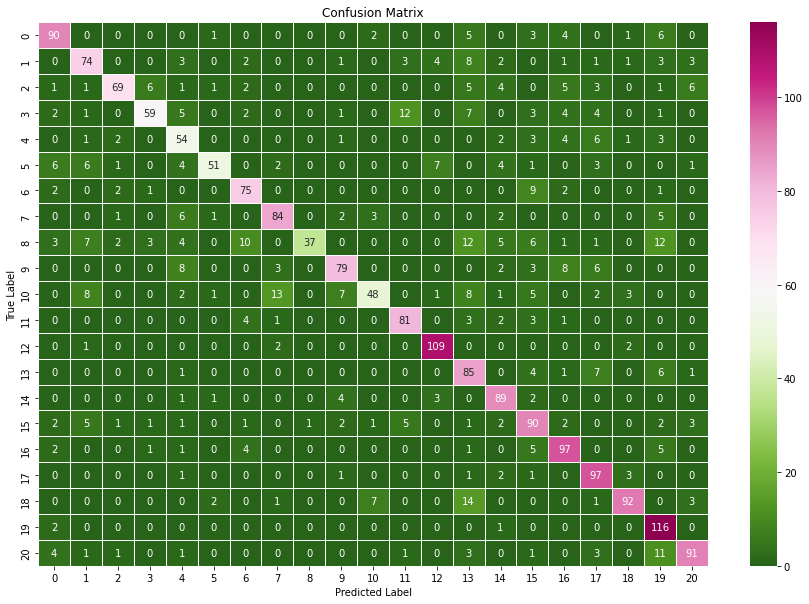

In [32]:
# Print confusion matrix for training data
y_pred_train = model.predict(X_train)

# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)

# confusion matrix
LABELS = [i for i in range(21)]

y_pred_test = model.predict(X_test)

# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(15, 10))
sns.heatmap(matrix,
            cmap='PiYG_r',
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()